#

# AIRBNB AND YELP REVIEWS DATA ANALYSIS

## DEV10 CAPSTONE PROJECT
## Introduction
We chose to work with Airbnb listing data and bring in data from Yelp API on surrounding restaurants and attractions in the vicinity of the listings. 

Some of the questions we wanted to investigate were:
- Is there any correlation between AirBnB ratings and nearby yelp locations 
- Is there a difference between NYC and Paris markets 
- What variables best predict the price of an AirBnB 
- Is there a strong difference within NYC's different boroughs 
- Does population correlate to more or higher priced AirBnBs 
- If it is not proportional to population, is it proportional to city size 
- Is there a significant difference between attraction/restaurant types in NYC vs Paris


## ETL
### Data Sources
Our data was extracted from Kaggle at the following link: [airbnb-listings-reviews](https://www.kaggle.com/datasets/mysarahmadbhat/airbnb-listings-reviews)
Our API data was consumed from the Yelp Fusion API at [Yelp](https://www.yelp.com/developers/documentation/v3/authentication)


We used Azure DataBricks for ETL. 

### Extraction
We used VSCode to call the Yelp API, which was extracted in JSON format, and then saved into .csv for efficiency in future processing. The consumed API data was saved as a binary large object file in our Azure Data Lake in the cohort50 resource group, within our AirJNJ storage container.

### Transformation
We then used Python Pandas in a Jupyter notebook in Databricks to load the data from the JSON file into dataframes.

### Load
We then loaded the data from the Jupyter Notebook into the AirJNJ SQL database for permanent storage using the following built-in:
*DataFrame.to_sql(name, con, schema=None, if_exists='fail', index=True, index_label=None, chunksize=None, dtype=None, method=None)*

| Column 1 | Column 2 | Column 3 |
|----------|----------|----------|
|   Row 1  |   Data   |   Data   |
|   Row 2  |   Data   |   Data   |


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn.objects as so
# from unidecode import unidecode

## Data Source 1
First, listings data is read into a pandas dataframe called 'listings'.

### *Please note..*
Since I'm doing EDA locally and have all the data locally, it will not run correctly in the git folder structure. (The airbnb dataset was too big to put on git and is located in our Azure blob storage container).

In [2]:
fn = './data/Listings.csv'
listings = pd.read_csv(fn,encoding='ISO-8859-1')

C:\Users\13073\AppData\Local\Temp\ipykernel_37956\3925082198.py:2: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  listings = pd.read_csv(fn,encoding='ISO-8859-1')


Let's take a look at all columns in the df.

In [3]:
listings.columns

Index(['listing_id', 'name', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'district', 'city', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable'],
      dtype='object')

And let's get a general lay of the land with some info on datatypes and null counts.

In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279712 entries, 0 to 279711
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   279712 non-null  int64  
 1   name                         279539 non-null  object 
 2   host_id                      279712 non-null  int64  
 3   host_since                   279547 non-null  object 
 4   host_location                278872 non-null  object 
 5   host_response_time           150930 non-null  object 
 6   host_response_rate           150930 non-null  float64
 7   host_acceptance_rate         166625 non-null  float64
 8   host_is_superhost            279547 non-null  object 
 9   host_total_listings_count    279547 non-null  float64
 10  host_has_profile_pic         279547 non-null  object 
 11  host_identity_verified       279547 non-null  object 
 12  neighbourhood                279712 non-null  object 
 13 

We can see what the most popular property type is (entire apartment) and also note some interesting one-offs, like teepee and train.

"Shared room in parking space" definitely doesn't sound like an Airbnb you'd want to advertise, but a train or teepee stay could be a unique experience!

In [5]:
listings.property_type.value_counts()

Entire apartment                138989
Private room in apartment        47322
Private room in house            13292
Entire house                     13273
Entire condominium               11250
                                 ...  
Shared room in floor                 1
Shared room in parking space         1
Shared room in tent                  1
Train                                1
Tipi                                 1
Name: property_type, Length: 144, dtype: int64

The Kaggle dataset contains Airbnb listing data from major cities around the world:

In [6]:
listings.city.value_counts()

Paris             64690
New York          37012
Sydney            33630
Rome              27647
Rio de Janeiro    26615
Istanbul          24519
Mexico City       20065
Bangkok           19361
Cape Town         19086
Hong Kong          7087
Name: city, dtype: int64

We can also get an idea of which cities are cheapest to stay in with an aggregate mean on each city.

In [7]:
pivot = pd.pivot_table(listings, values='price', index=['city'], aggfunc='mean')
pivot

,price
city,
Bangkok,2078.278033
Cape Town,2405.120350
Hong Kong,746.169889
Istanbul,532.557445
Mexico City,1149.253028
New York,142.842240
Paris,113.096445
Rio de Janeiro,742.589254
Rome,105.107643


We selected NYC and Paris for the study to pare down the dataset to just over 100,000 rows, making it more manageable but still large enough to produce meaningful results in machine learning.

In [8]:
#create NY and Paris df
NY = listings[listings.city == 'New York']
display(NY.head())

Paris = listings[listings.city == 'Paris']
display(Paris.head())

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
9220,3457770,Cute 1 BR in the Lower East Side,9604972,2013-10-23,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,30,1125,80.0,10.0,8.0,8.0,8.0,10.0,10.0,f
9221,4173751,Lovely Apartment in Harlem West,9197440,2013-10-02,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,30,1125,90.0,10.0,9.0,10.0,10.0,9.0,9.0,f
9222,4259427,Appartement en duplex de 3 chambres,21833312,2014-09-27,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,6,1125,87.0,9.0,8.0,10.0,10.0,8.0,8.0,f
9223,4370230,NaN,22686810,2014-10-18,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,30,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
9224,5286096,Amazing Studio-EmpireStateBuilding,3866196,2012-10-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,30,1125,93.0,9.0,9.0,9.0,10.0,9.0,9.0,f


,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
1,3705183,39 mÃÂ² Paris (Sacre CÃ âur),10328771,2013-11-29,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
2,4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
3,4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
4,4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,...,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f


Because NYC is more populous than Paris (8.5 million vs 2 million), we decided to split NYC into its 5 boroughs, so they are a bit closer in population and number of zip codes.

Bronx: 1.3 mil, 25 zip codes

Brooklyn: 2.5 mil, 37 zip codes

Manhattan: 1.6 mil, 43 zip codes

Queens: 2.2 mil, 61 zip codes

Staten Island: 490k, 12 zip codes

Paris: 2.1 mil, 20 zip codes

In [9]:
districts=NY[['city','district']].drop_duplicates().sort_values(by=['district'])
display(districts.district.count())
districts

5

,city,district
12833,New York,Bronx
9222,New York,Brooklyn
9220,New York,Manhattan
11623,New York,Queens
13741,New York,Staten Island


A quick pivot table aggregate shows Manhattan is the priciest place to stay on average, and the Bronx is the cheapest.

In [10]:
pivot_NY = pd.pivot_table(NY, values='price', index=['city', 'district'], aggfunc='mean')
pivot_NY


price
city     district                 
New York Bronx           93.698589
         Brooklyn       119.059486
         Manhattan      179.434423
         Queens          99.684736
         Staten Island  109.224913

One strange finding is that the number of minimum nights listed by an owner ranges from 1 night - a logical constraint - all the way up to 9999 nights. 

It's worth asking, is this some glitch/error we can attribute to the method of data collection for the the Kaggle dataset, or are owners possibly increasing the min nights to stay rather than delete the listing permanently? It seems unlikely Airbnb would permit an entry like 600 nights minimum stay. 

Stepping back to evaluate the effect this would have on our analyses, this does not appear to be a factor that would decrease the quality of our model(s) in any way, so we will simply note it and move on.

In [11]:
min_nights=listings[['minimum_nights']].drop_duplicates().sort_values(by='minimum_nights')
display(min_nights.count())
display(min_nights)
min_nights.tail(15)

minimum_nights    202
dtype: int64

,minimum_nights
117,1
0,2
191,3
192,4
198,5
...,...
177550,1123
5316,1124
11492,1125
255298,1250


,minimum_nights
7690,600
18853,630
170393,700
82663,720
54080,730
20411,999
13071,1000
373,1001
38446,1100
89324,1112


In [12]:
max_nights=listings[['maximum_nights']].drop_duplicates().sort_values(by='maximum_nights')
display(max_nights.count())
max_nights

maximum_nights    508
dtype: int64

,maximum_nights
157687,1
157628,2
157610,3
157601,4
157649,5
...,...
159137,999999
197754,10000000
196791,20000000
268454,999999999


Taking a look at unique prices for listings in NY and Paris dataframes reveals pretty similar spreads, with some points on the extremely low end and extremely high end and centered around values the average consumer might expect to pay for a night in a rental home.

One value in the price column that raises concern is $0. We should not drop these, since the rest of the row can still be used for review rating modeling, but since zeros artificially reduce the average in the column, we should drop them when we create a model with price as a target.

In [13]:
prices_NY=NY[['price']].drop_duplicates().sort_values(by='price')
display(prices_NY.count())
display(prices_NY)

prices_P=Paris[['price']].drop_duplicates().sort_values(by='price')
display(prices_P.count())
prices_P

price    733
dtype: int64

,price
202022,0
15134,10
106328,14
107053,15
90075,16
...,...
195074,7314
200016,9000
119943,9990
17674,9999


price    801
dtype: int64

,price
98209,0
2042,8
58229,9
5652,10
5537,12
...,...
45174,9280
28872,9631
227298,10250
60735,11599


Review scores are on a scale of 0 to 100, and we will remain cognizant of the NaNs in some rows. These should not impact the machine learning modeling we intend to do, but it is worth noting.

In [14]:
pd.options.display.max_rows = 10
review_scores=listings[['review_scores_rating']].drop_duplicates().sort_values(by='review_scores_rating')
display(review_scores.count())
display(review_scores)

review_scores_rating    63
dtype: int64

,review_scores_rating
1984,20.0
3533,27.0
18335,30.0
45893,31.0
16972,33.0
...,...
377,97.0
371,98.0
372,99.0
0,100.0


Similarly, the review scores for drilldown categories (like cleanliness, location, and communication) are scaled of 0 to 10 but also have some NaN rows.

In [15]:
review_drilldown=listings[['review_scores_value']].drop_duplicates().sort_values(by='review_scores_value')
display(review_drilldown.count())
display(review_drilldown)

review_scores_value    9
dtype: int64

,review_scores_value
1311,2.0
16287,3.0
1514,4.0
1974,5.0
1033,6.0
1390,7.0
1025,8.0
805,9.0
0,10.0
1705,NaN


The amenities column can be viewed most easily in its raw form with a to_dict conversion, although any further work with these values will probably require splitting them out with a .explode or similar.

In [39]:
amenities=listings[['amenities']].drop_duplicates().to_dict()
amenities

{'amenities': {0: '["Heating", "Kitchen", "Washer", "Wifi", "Long term stays allowed"]',
  1: '["Shampoo", "Heating", "Kitchen", "Essentials", "Washer", "Dryer", "Wifi", "Long term stays allowed"]',
  2: '["Heating", "TV", "Kitchen", "Washer", "Wifi", "Long term stays allowed"]',
  3: '["Heating", "TV", "Kitchen", "Wifi", "Long term stays allowed"]',
  4: '["Heating", "TV", "Kitchen", "Essentials", "Hair dryer", "Washer", "Dryer", "Bathtub", "Wifi", "Elevator", "Long term stays allowed", "Cable TV"]',
  5: '["Heating", "TV", "Kitchen", "Essentials", "Washer", "Smoke alarm", "Wifi", "Long term stays allowed", "Cable TV"]',
  6: '["Shampoo", "TV", "Kitchen", "Washer", "Smoke alarm", "Wifi", "Fire extinguisher", "Long term stays allowed"]',
  7: '["Heating", "TV", "Kitchen", "Essentials", "Washer", "Dryer", "Smoke alarm", "Wifi", "Long term stays allowed"]',
  8: '["Paid parking off premises", "Shampoo", "Heating", "TV", "Iron", "Kitchen", "Hair dryer", "Essentials", "Washer", "Hot water"

The 'accomodates' column shows how many persons the listing can accomodate. Value counts reveal values in the realm of reasonable, with the exception of 'accomodates - 0' which makes no sense but has 85 such listings. Again, we will make note but take no action to remove these rows at this time.

In [35]:
listings[['accommodates']].value_counts()

accommodates
2               118332
4                57260
3                27936
1                25813
6                19455
                 ...  
11                 367
14                 331
15                 214
13                 197
0                   85
Length: 17, dtype: int64

Most listings are 1-bedrooms, and there a few very large listings with 25+ bedrooms.

In [36]:
listings[['bedrooms']].value_counts()

bedrooms
1.0         170163
2.0          51382
3.0          18525
4.0           6579
5.0           2106
             ...  
25.0             1
34.0             1
41.0             1
42.0             1
48.0             1
Length: 39, dtype: int64

Now that we've thoroughly examined the fields and potential pitfalls, let's create some plots to visualize what the most important factors might be as predictors.

For the scatter plot, let's grab only the numerical data by dropping columns of object (string) type data and also dropping the nans for simplicity in this rough first look. 

Let's also remove the target 'price.'

...And let's do both independently for Paris and New York dfs, since the European market may reveal different trends than a US market.

In [19]:
num_cols = NY.columns[NY.dtypes != 'object'].dropna()
NY_num=NY[num_cols].dropna()

# drop y
num_cols = num_cols.drop('price')


num_cols_P = Paris.columns[Paris.dtypes != 'object'].dropna()
Paris_num=Paris[num_cols_P].dropna()

# drop y
num_cols_P = num_cols_P.drop('price')

Display heads to make sure there's no funny business going on here...

In [20]:
display(NY_num.head())
display(Paris_num.head())

,listing_id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
26276,42449656,308165996,1.0,1.0,1.0,40.69924,-73.92763,2,1.0,125,30,1125,90.0,10.0,10.0,10.0,8.0,10.0,9.0
26277,44358310,301703046,1.0,1.0,1.0,40.74747,-73.98991,5,1.0,175,30,1125,65.0,8.0,8.0,8.0,7.0,9.0,7.0
26320,457829,2275829,1.0,1.0,1.0,40.72917,-73.98811,4,1.0,110,30,1125,85.0,9.0,9.0,9.0,9.0,10.0,9.0
26321,4956469,25537637,1.0,1.0,1.0,40.75830,-73.77232,4,1.0,81,2,1125,93.0,9.0,9.0,10.0,9.0,9.0,9.0
26322,7962707,42008401,1.0,1.0,1.0,40.75403,-73.91814,4,1.0,140,1,1125,93.0,10.0,9.0,10.0,9.0,9.0,10.0


,listing_id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
26273,39849253,305389411,1.0,1.0,1.0,48.86015,2.38187,2,1.0,89,1,1125,73.0,7.0,7.0,7.0,7.0,7.0,7.0
26274,40436816,312774780,1.0,1.0,1.0,48.89423,2.32657,4,1.0,98,1,1125,80.0,8.0,10.0,10.0,8.0,10.0,8.0
26275,40546536,314090203,1.0,1.0,1.0,48.85986,2.38311,2,1.0,75,1,1125,80.0,10.0,10.0,7.0,8.0,10.0,8.0
26286,810675,4263009,1.0,1.0,1.0,48.83187,2.32909,3,1.0,75,5,1125,93.0,9.0,8.0,10.0,9.0,10.0,9.0
26287,1358489,6577904,1.0,1.0,1.0,48.88046,2.36148,4,1.0,90,10,1125,90.0,10.0,8.0,10.0,9.0,9.0,8.0


And finally, use seaborn objects to plot a pair plot of each x against the y ("price"). This code creates separate plots for each of the markets: NYC and Paris.

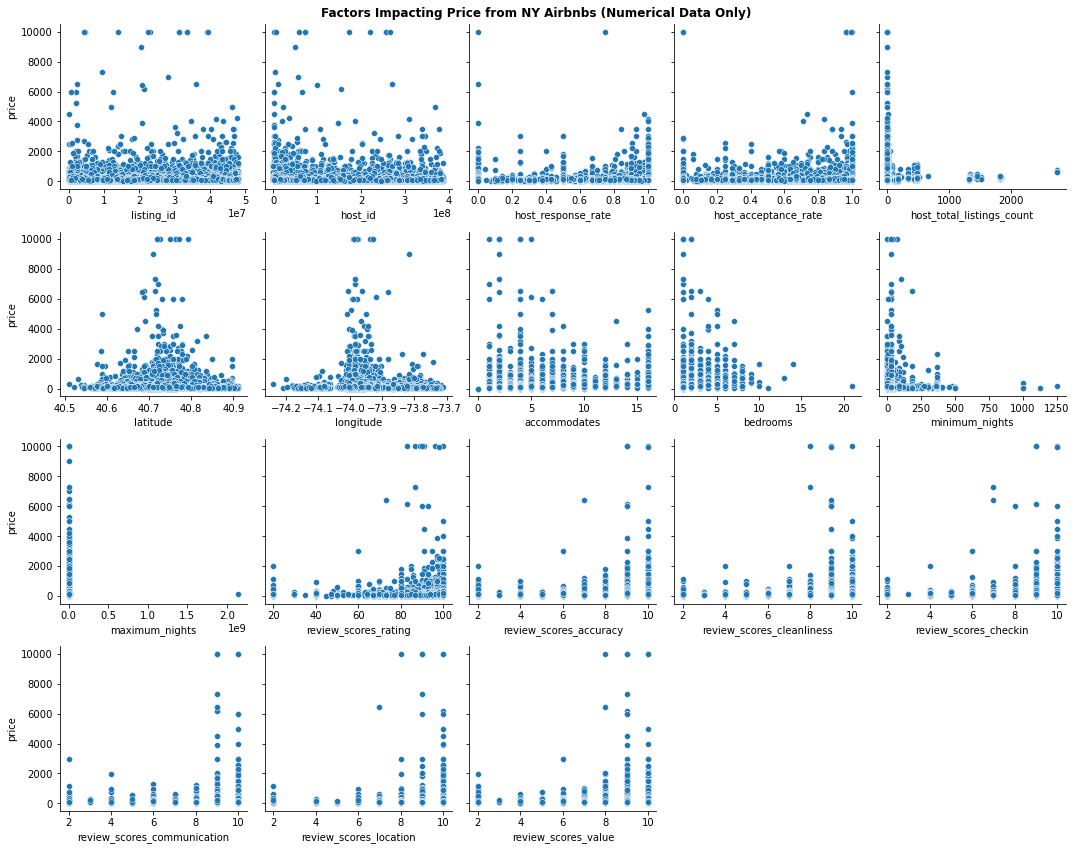

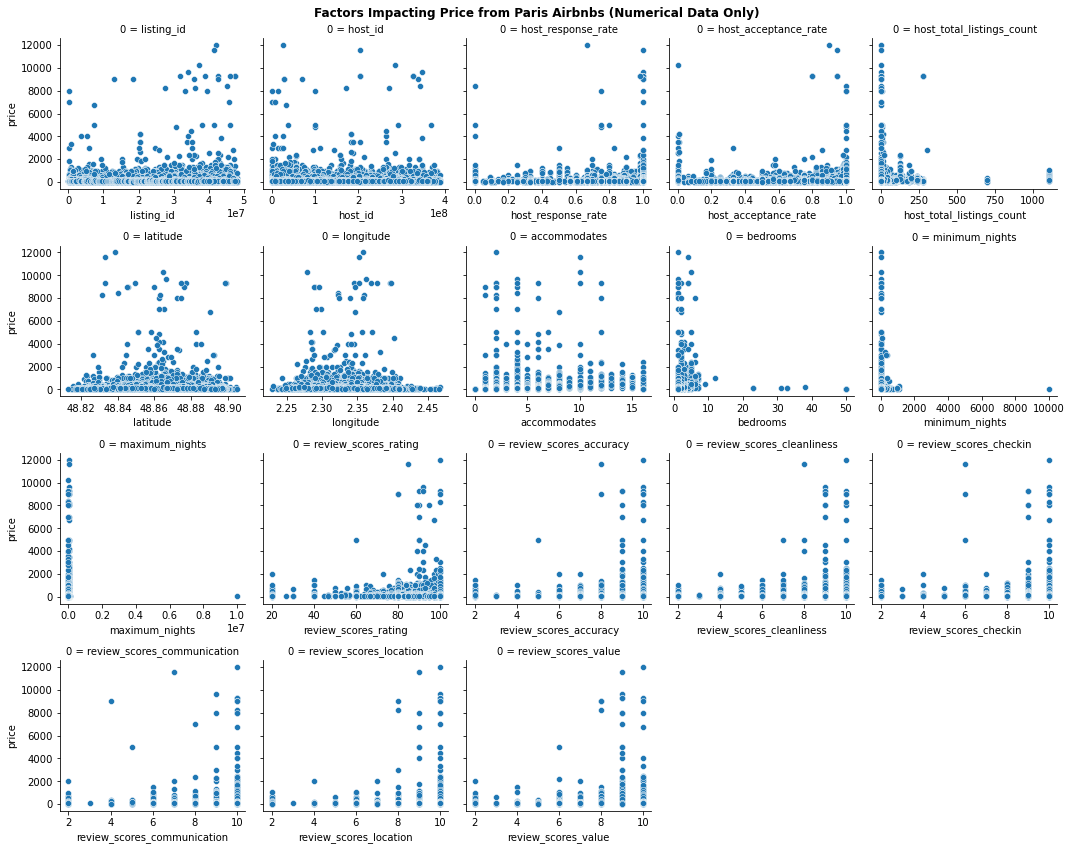

In [25]:
x_vars=num_cols
y_var="price"

g = sns.FacetGrid(pd.DataFrame(x_vars), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g.axes, x_vars):
    sns.scatterplot(data=NY, x=x_var, y=y_var, ax=ax)
    g.set_titles(row_template='', col_template='')


g.fig.suptitle("Factors Impacting Price from NY Airbnbs (Numerical Data Only)", fontsize='large', fontweight='bold')

g.tight_layout()
g.fig.savefig('img/Factors Impacting Price from NY Airbnbs.png')

x_vars_P=num_cols_P

g1 = sns.FacetGrid(pd.DataFrame(x_vars_P), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g1.axes, x_vars_P):
    sns.scatterplot(data=Paris, x=x_var, y=y_var, ax=ax)
    g.set_titles(row_template='', col_template='')


g1.fig.suptitle("Factors Impacting Price from Paris Airbnbs (Numerical Data Only)", fontsize='large', fontweight='bold')

g1.tight_layout()
g1.fig.savefig('img/Factors Impacting Price from Paris Airbnbs.png')

Two very clear patterns stick out: 
- first, the closer a listing is to the center of the city, the higher its price. This more evident in NYC than in Paris. 
- second, there is some apparent positive correlation between price and ratings, where very low ratings correlate to very low price and very high ratings sometimes correlate to high price, but may be a poor conclusion that ratings are the strongest predictor of price. This is clear by the dense clustering of points around low priced listings with high ratings - ones that might fall into a "great value" category. A more conservative interpretation of this trend might be that listings with poor ratings are forced into lower prices if they want to continue getting business at all.

In [22]:
num_cols1 = NY.columns[NY.dtypes != 'object'].dropna()
NY_num1=NY[num_cols1].dropna()

# drop y
num_cols1 = num_cols1.drop('review_scores_rating')

NY_num1.head()

,listing_id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
26276,42449656,308165996,1.0,1.0,1.0,40.69924,-73.92763,2,1.0,125,30,1125,90.0,10.0,10.0,10.0,8.0,10.0,9.0
26277,44358310,301703046,1.0,1.0,1.0,40.74747,-73.98991,5,1.0,175,30,1125,65.0,8.0,8.0,8.0,7.0,9.0,7.0
26320,457829,2275829,1.0,1.0,1.0,40.72917,-73.98811,4,1.0,110,30,1125,85.0,9.0,9.0,9.0,9.0,10.0,9.0
26321,4956469,25537637,1.0,1.0,1.0,40.75830,-73.77232,4,1.0,81,2,1125,93.0,9.0,9.0,10.0,9.0,9.0,9.0
26322,7962707,42008401,1.0,1.0,1.0,40.75403,-73.91814,4,1.0,140,1,1125,93.0,10.0,9.0,10.0,9.0,9.0,10.0


Let's see if the listing data on its own reveals any correlations with review scores as the predictor now instead of price.

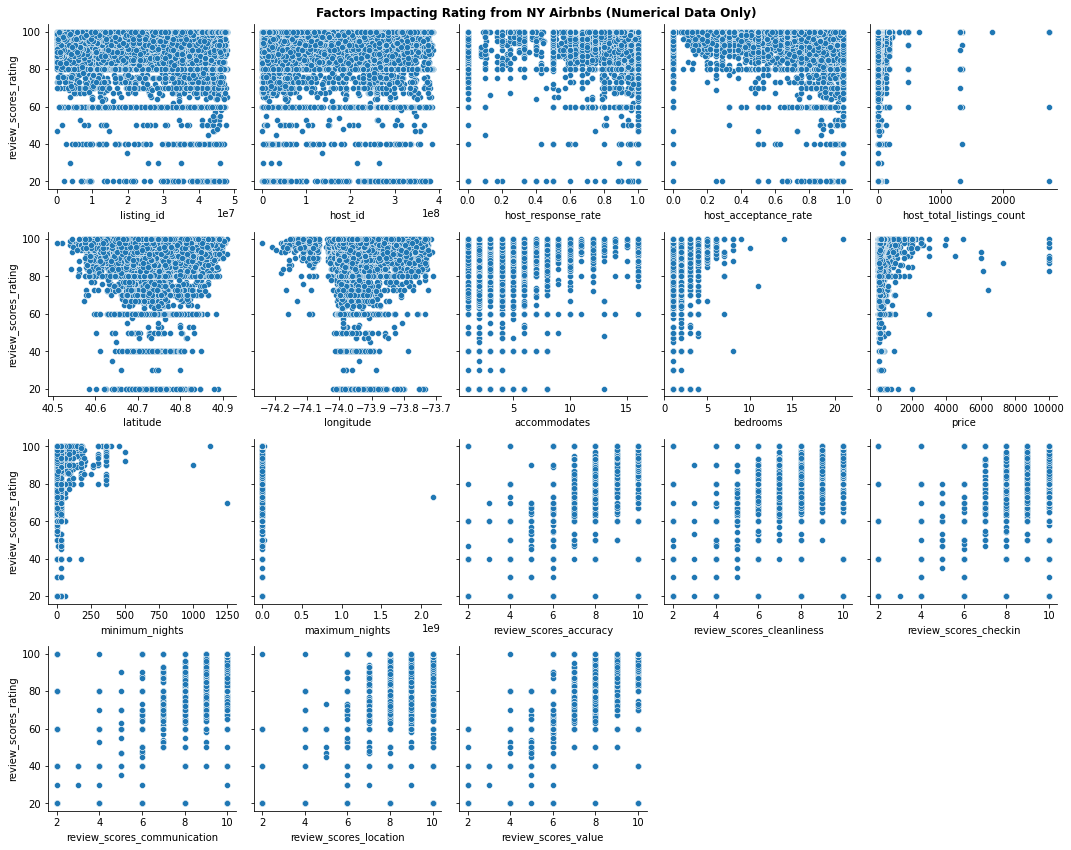

In [23]:
x_vars1=num_cols1
y_var1="review_scores_rating"

g = sns.FacetGrid(pd.DataFrame(x_vars1), col=0, col_wrap=5, sharex=False)
for ax, x_vars1 in zip(g.axes, x_vars1):
    sns.scatterplot(data=NY, x=x_vars1, y=y_var1, ax=ax)
    g.set_titles(row_template='', col_template='')


g.fig.suptitle("Factors Impacting Rating from NY Airbnbs (Numerical Data Only)", fontsize='large', fontweight='bold')

g.tight_layout()

There is no strong correlation except between the inherently linked values (review overall and review for each category). This is actually promising for when we go to fit machine learning models with nearby yelp attractions, since any trends will naturally be decoupled from the listing features.